In [3]:
from qdisk.plot import ChannelMap, Map
from eDisk_source_dict import source_dict
import matplotlib.pyplot as plt
from matplotlib import ticker
from astropy.visualization import AsinhStretch, SinhStretch
import matplotlib.patheffects as pe
from matplotlib import patches
import eDiskplot as eplot
from qdisk.classes import FitsImage
import numpy as np
import analysis_utils as au
%matplotlib widget
%load_ext autoreload
%autoreload 2

source = "L1489IRS"
config = "SBLB"
lines = ["12CO", "13CO", "C18O", "SO"]
robust = {"12CO": 0.5, "13CO": 1.0, "C18O": 1.0, "SO": 1.0}
dv = 0.2
center_coord = source_dict[source]["radec"]
PA = source_dict[source]["PA"]
incl = source_dict[source]["incl"]
distance = source_dict[source]["distance"]
vsys = source_dict[source]["vsys"]
vrange = 6
nu0 = source_dict[source]["cont_nu0"]

def arcsec2au(r):
    return r * distance

def au2arcsec(r):
    return r / distance

### add beam prfoiel
def add_beam_profile(ax, beam, width_aspect=0.2, loc="upper right", aspect=0.6):
    xmin, xmax = ax.get_xlim()
    width = beam / (xmax - xmin) / width_aspect
    height = width * aspect
    if loc == "upper right":
        loc = [0.95-width, 0.95-height, width, height]
    elif loc == "lower left":
        loc = [0.05, 0.05, width, height]
    insax = ax.inset_axes(loc)
    x = np.arange(-0.5, 0.5, 0.001)
    beam_sigma = au.FWHM_to_sigma(width_aspect)
    y = np.exp(- x**2/(2*beam_sigma**2))
    insax.plot(x, y, color="grey")
    insax.axis("off")

contimagename = "/works/yamato/eDisk/L1489IRS/try1/trial_image_backup/L1489IRS_SBLB_continuum_robust_1.0.image.tt0.fits"

# continuum rms
contimage = FitsImage(contimagename)
contimage.estimate_rms(rmin=6)
contrms = contimage.rms
print("continuum beam size: {}'' x {}''".format(contimage.bmaj, contimage.bmin))
print("continuum rms: {:.3f} mJy/beam".format(contrms*1e3))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
continuum beam size: 0.10507912188768'' x 0.07762632519006''
continuum rms: 0.014 mJy/beam


In [4]:
from uncertainties import ufloat
compact = ufloat(5.610, np.sqrt(0.027**2 + 0.561**2))
broad = ufloat(81.79, np.sqrt(0.97**2 + 8.179**2))
compact + broad
# 116/14

87.4+/-8.25544614179028

In [8]:
87.4/59

1.48135593220339

'\n# radial profile\nax = axes[3]\nrobust = 1.0\n\nfor side in ["West", "East", ""]:\n    profilename = au.VADPpath + au.get_image_basename(\n        source=source, line="continuum", baseline=config, robust=robust, type="image"\n    ).replace(".fits", f"_radialProfileWedge45deg{side}.txt")\n\n    r, I, dI = np.loadtxt(profilename, unpack=True)\n    I *= 1e3\n    dI *= 1e3\n\n    color = "black" if side == "" else "grey"\n    ls = "solid" if side == "" else "dotted" if side == "West" else "dashed"\n    ax.plot(r, I, color=color, ls=ls, label=side.lower() if side != "" else "both")\n    ax.fill_between(r, I-dI, I+dI, alpha=0.25, facecolor="black", edgecolor=None)\n    ax.set(xlim=(0, 4.3))\n\ntopax = ax.secondary_xaxis("top", functions=(arcsec2au, au2arcsec))\ntopax.xaxis.set_major_locator(ticker.MultipleLocator(150))\ntopax.minorticks_on()\ntopax.tick_params(axis=\'x\', which=\'major\', pad=1)\nax.xaxis.set_major_locator(ticker.MultipleLocator(1))\n\nax.minorticks_on()\nax.tick_params(t

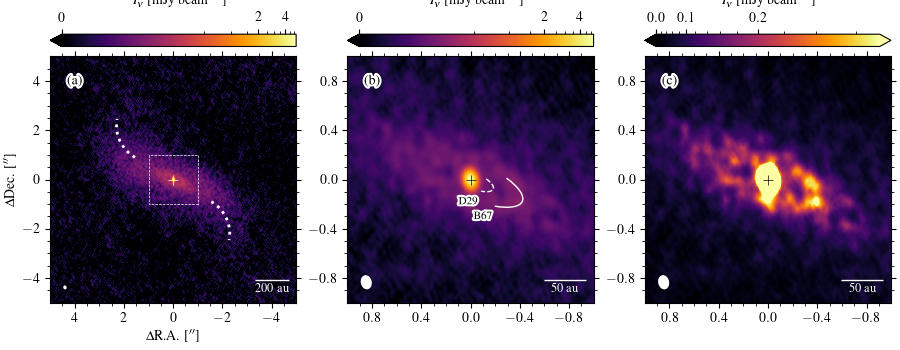

In [17]:
# continuum maps
fig, axes = plt.subplots(1,3, figsize=(9,3.5), constrained_layout=True)
ring_pos = 0.456
gap_pos = 0.2

# large scale view
ax = axes[0]
rmax = 5.0
contmap = Map(contimagename, ax=ax, data_scaling_factor=1e3, xlim=(-rmax, rmax), ylim=(-rmax, rmax), center_coord=center_coord)
contmap.plot_colormap(cmap=eplot.cmap["continuum"], vmin=0.0, stretch=AsinhStretch(a=0.005))
contmap.add_colorbar(position="top", label="$I_\\nu$ [mJy beam$^{-1}$]", rotation=0, labelpad=5)
contmap.colorbar.ax.minorticks_on()
contmap.add_beam()
contmap.add_scalebar(scale=200. / distance, text="{:d} au".format(200))
contmap.set_labels(xlabel=eplot.RAlabel, ylabel=eplot.Declabel)
box = patches.Rectangle(
    xy=(-1, -1),
    width=2,
    height=2,
    fill=False,
    ls="dashed",
    color="white",
    lw=0.5,
)
arc1 = patches.Arc(
    xy=(-0.8, -2.2),
    width=3,
    height=3,
    theta1=120,
    theta2=190,
    color="white",
    ls="dotted",
    lw=2,
)
arc2 = patches.Arc(
    xy=(0.8, 2.2),
    width=3,
    height=3,
    theta1=120 + 180,
    theta2=190 + 180,
    color="white",
    ls="dotted",
    lw=2,
)
contmap.ax.add_artist(box)
contmap.ax.add_artist(arc1)
contmap.ax.add_artist(arc2)
contmap.ax.annotate(text="(a)", xy=(0.1, 0.9), xycoords="axes fraction", color="black", ha="center", va="center", path_effects=[pe.Stroke(linewidth=3, foreground="white"), pe.Normal()])
contmap.set_ticker(minor=True, majornticks=5, minornticks=5)
contmap.ax.scatter(0, 0, marker="+", s=50, color="white", linewidth=0.5)

# zoom in view
ax = axes[1]
rmax = 1.0
contmap = Map(contimagename, ax=ax, data_scaling_factor=1e3, xlim=(-rmax, rmax), ylim=(-rmax, rmax), center_coord=center_coord)
contmap.plot_colormap(cmap=eplot.cmap["continuum"], vmin=0.0, stretch=AsinhStretch(a=0.02))
contmap.add_colorbar(position="top", label="$I_\\nu$ [mJy beam$^{-1}$]", rotation=0, labelpad=5)
contmap.colorbar.ax.minorticks_on()
contmap.add_beam()
contmap.add_scalebar(scale=50. / distance, text="{:d} au".format(50))
arc_ring = patches.Arc(
            xy=(0, 0),
            width=2 * ring_pos,
            height=2 * ring_pos * np.cos(np.radians(incl)),
            angle=90 - PA,
            color="white",
            theta1=155,
            theta2=205,
        )
contmap.ax.annotate(text="B{:.0f}".format(ring_pos*distance), xy=(-0.1, -0.3), color="black", ha="center", va="center", size=8, path_effects=[pe.Stroke(linewidth=3, foreground="white"), pe.Normal()])
arc_gap = patches.Arc(
    xy=(0, 0),
    width=2 * gap_pos,
    height=2 * gap_pos * np.cos(np.radians(incl)),
    angle=90 - PA,
    color="white",
    theta1=155,
    theta2=205,
    ls="dashed",
)
contmap.ax.annotate(text="D{:.0f}".format(gap_pos*distance), xy=(0.02, -0.18), color="black", ha="center", va="center", size=8, path_effects=[pe.Stroke(linewidth=3, foreground="white"), pe.Normal()])
contmap.ax.add_artist(arc_ring)
contmap.ax.add_artist(arc_gap)
contmap.ax.annotate(text="(b)", xy=(0.1, 0.9), xycoords="axes fraction", color="black", ha="center", va="center", path_effects=[pe.Stroke(linewidth=3, foreground="white"), pe.Normal()])
contmap.set_ticker(minor=True, majornticks=5, minornticks=5)
contmap.ax.scatter(0, 0, marker="+", s=50, color="black", linewidth=0.5)

# asymmetry
ax = axes[2]
rmax = 1.0
contmap = Map(contimagename, ax=ax, data_scaling_factor=1e3, xlim=(-rmax, rmax), ylim=(-rmax, rmax), center_coord=center_coord)
contmap.plot_colormap(cmap=eplot.cmap["continuum"], vmin=0.0, vmax=0.27, stretch=SinhStretch())
contmap.add_colorbar(position="top", label="$I_\\nu$ [mJy beam$^{-1}$]", rotation=0, labelpad=5)
contmap.colorbar.ax.minorticks_on()
contmap.add_beam()
contmap.add_scalebar(scale=50. / distance, text="{:d} au".format(50))
contmap.ax.annotate(text="(c)", xy=(0.1, 0.9), xycoords="axes fraction", color="black", ha="center", va="center", path_effects=[pe.Stroke(linewidth=3, foreground="white"), pe.Normal()])
contmap.set_ticker(minor=True, majornticks=5, minornticks=5)
contmap.ax.scatter(0, 0, marker="+", s=50, color="black", linewidth=0.5)


# # radial profile
# ax = axes[3]
# robust = 1.0

# for side in ["West", "East", ""]:
#     profilename = au.VADPpath + au.get_image_basename(
#         source=source, line="continuum", baseline=config, robust=robust, type="image"
#     ).replace(".fits", f"_radialProfileWedge45deg{side}.txt")

#     r, I, dI = np.loadtxt(profilename, unpack=True)
#     I *= 1e3
#     dI *= 1e3

#     color = "black" if side == "" else "grey"
#     ls = "solid" if side == "" else "dotted" if side == "West" else "dashed"
#     ax.plot(r, I, color=color, ls=ls, label=side.lower() if side != "" else "both")
#     ax.fill_between(r, I-dI, I+dI, alpha=0.25, facecolor="black", edgecolor=None)
#     ax.set(xlim=(0, 4.3))

# topax = ax.secondary_xaxis("top", functions=(arcsec2au, au2arcsec))
# topax.xaxis.set_major_locator(ticker.MultipleLocator(150))
# topax.minorticks_on()
# topax.tick_params(axis='x', which='major', pad=1)
# ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

# ax.minorticks_on()
# ax.tick_params(top=False, which="both")


# # if line == "continuum":
# ax.set(yscale="log", ylim=(6e-3, 2e1), ylabel="$I_\\nu$ [mJy beam$^{-1}$]", xlabel="Radius [$^{\prime\prime}$]")
# topax.set_xlabel("Radius [au]", labelpad=7)
# # topax.set
# # topax.minorticks_on()
# ax.annotate(
#     text="(d)",
#     xy=(0.04, 0.93),
#     xycoords="axes fraction",
#     color="black",
#     ha="left",
#     va="center",
#     path_effects=[pe.Stroke(linewidth=3, foreground="white"), pe.Normal()],
# )
# add_beam_profile(ax, beam=4*np.diff(r).mean(), loc="lower left")

# # inset axis for zoom
# insax = ax.inset_axes([0.48, 0.4, 0.46, 0.48])
# xmin, xmax, ymin, ymax = 0.05, 0.9, 0.07, 0.3
# insax.set(xlim=(xmin, xmax), ylim=(ymin, ymax))
# topinsax = insax.secondary_xaxis("top", functions=(arcsec2au, au2arcsec))
# insax.tick_params(top=False)
# topinsax.xaxis.set_major_locator(ticker.MultipleLocator(30))
# topinsax.tick_params(axis='x', which='major', pad=0.1)
# insax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
# insax.yaxis.set_major_locator(ticker.MultipleLocator(0.04))

# # set patheffect
# for ticks in insax.get_xticklabels():
#     ticks.set_path_effects([pe.Stroke(linewidth=3, foreground="white"), pe.Normal()])
# for ticks in insax.get_yticklabels():
#     ticks.set_path_effects([pe.Stroke(linewidth=3, foreground="white"), pe.Normal()])
# for side in ["West", "East", ""]:
#     profilename = au.VADPpath + au.get_image_basename(
#             source=source, line="continuum", baseline=config, robust=robust, type="image"
#         ).replace(".fits", f"_radialProfileWedge45deg{side}.txt")

#     r, I, dI = np.loadtxt(profilename, unpack=True)
#     I *= 1e3
#     dI *= 1e3

#     color = "black" if side == "" else "grey"
#     ls = "solid" if side == "" else "dotted" if side == "West" else "dashed"
#     insax.plot(r, I, color=color, ls=ls)
#     insax.fill_between(r, I-dI, I+dI, alpha=0.25, facecolor="black", edgecolor=None)
# ax.indicate_inset_zoom(insax, edgecolor="black")
# add_beam_profile(insax, beam=4*np.diff(r).mean(), aspect=0.5, width_aspect=0.3)


# def jypb2K(I):
#     return au.jypb_to_K(I*1e-3, nu0, contmap.beam[:2])

# def K2jypb(I):
#     return au.K_to_jypb(I, nu0, contmap.beam[:2])

# rightax = ax.secondary_yaxis("right", functions=(jypb2K, K2jypb))
# ax.tick_params(which="both", right=False)
# rightax.set_ylabel("$T_\mathrm{B}$ [K]", labelpad=7, rotation=270)

# fig.savefig("./figure/continuum_gallery.pdf", bbox_inches="tight", pad_inches=0.01)

In [18]:
fig.savefig("./figure/continuum_maps_profiles.pdf", bbox_inches="tight", pad_inches=0.01)

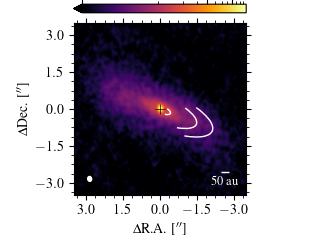

In [9]:
# tapered continuum map
fig, ax = plt.subplots(constrained_layout=True)

contimagename = "/works/yamato/eDisk/L1489IRS/ALMA_pipeline_calibrated_data/L1489IRS_SBLB_continuum_robust_1.0_taper_1000klambda.image.tt0.fits"

rmax = 3.5
contmap = Map(contimagename, ax=ax, data_scaling_factor=1e3, xlim=(-rmax, rmax), ylim=(-rmax, rmax), center_coord=center_coord)
contmap.plot_colormap(cmap=eplot.cmap["continuum"], vmin=0.0, stretch=AsinhStretch(a=0.02))
contmap.add_colorbar(position="top", label="$I_\\nu$ [mJy beam$^{-1}$]", rotation=0, labelpad=5)
contmap.colorbar.ax.minorticks_on()
contmap.add_beam()
contmap.add_scalebar(scale=50. / distance, text="{:d} au".format(50))

ring_pos = 0.456
arc_ring1 = patches.Arc(
            xy=(0, 0),
            width=2 * ring_pos,
            height=2 * ring_pos * np.cos(np.radians(incl)),
            angle=90 - PA,
            color="white",
            theta1=155,
            theta2=205,
        )

ring_pos = 1.6
arc_ring2 = patches.Arc(
            xy=(0, 0),
            width=2 * ring_pos,
            height=2 * ring_pos * np.cos(np.radians(incl)),
            angle=90 - PA,
            color="white",
            theta1=155,
            theta2=205,
        )

ring_pos = 2.3
arc_ring3 = patches.Arc(
            xy=(0, 0),
            width=2 * ring_pos,
            height=2 * ring_pos * np.cos(np.radians(incl)),
            angle=90 - PA,
            color="white",
            theta1=155,
            theta2=205,
        )
# contmap.ax.annotate(text="B{:.0f}".format(ring_pos*distance), xy=(-0.1, -0.3), color="black", ha="center", va="center", size=8, path_effects=[pe.Stroke(linewidth=3, foreground="white"), pe.Normal()])
# arc_gap = patches.Arc(
#     xy=(0, 0),
#     width=2 * gap_pos,
#     height=2 * gap_pos * np.cos(np.radians(incl)),
#     angle=90 - PA,
#     color="white",
#     theta1=155,
#     theta2=205,
#     ls="dashed",
# )
# contmap.ax.annotate(text="D{:.0f}".format(gap_pos*distance), xy=(0.02, -0.18), color="black", ha="center", va="center", size=8, path_effects=[pe.Stroke(linewidth=3, foreground="white"), pe.Normal()])
contmap.ax.add_artist(arc_ring1)
contmap.ax.add_artist(arc_ring2)
contmap.ax.add_artist(arc_ring3)
# contmap.ax.annotate(text="(b)", xy=(0.1, 0.9), xycoords="axes fraction", color="black", ha="center", va="center", path_effects=[pe.Stroke(linewidth=3, foreground="white"), pe.Normal()])
contmap.set_ticker(minor=True, majornticks=5, minornticks=5)
contmap.ax.scatter(0, 0, marker="+", s=50, color="black", linewidth=0.5)
contmap.set_labels(xlabel=eplot.RAlabel, ylabel=eplot.Declabel)

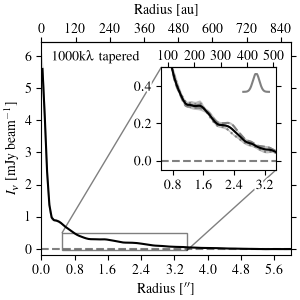

In [60]:
# tapered radial profile for outer rings
fig, ax = plt.subplots(figsize=(3, 3), constrained_layout=True)
robust = 2.0
side = ""

profilename = au.VADPpath + au.get_image_basename(
    source=source, line="continuum", baseline=config, robust=robust, type="image", other="taper_1000klambda"
).replace(".fits", f"_radialProfileWedge45deg{side}.txt")

r, I, dI = np.loadtxt(profilename, unpack=True)
I *= 1e3
dI *= 1e3

color = "black" if side == "" else "grey"
ls = "solid" if side == "" else "dotted" if side == "West" else "dashed"
ax.plot(r, I, color=color, ls=ls, label=side.lower() if side != "" else "both")
ax.fill_between(r, I-dI, I+dI, alpha=0.25, facecolor="black", edgecolor=None)
ax.set(xlim=(0, 6))

topax = ax.secondary_xaxis("top", functions=(arcsec2au, au2arcsec))
topax.xaxis.set_major_locator(ticker.MultipleLocator(120))
topax.tick_params(axis='x', which='major', pad=1)
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.8))
# ax.minorticks_on()
ax.tick_params(top=False)


# if line == "continuum":
ax.set(ylim=(-0.2, None), ylabel="$I_\\nu$ [mJy beam$^{-1}$]", xlabel="Radius [$^{\prime\prime}$]")
ax.axhline(y=0.0, color="grey", ls="dashed", zorder=-100)
topax.set_xlabel("Radius [au]", labelpad=7)
# topax.set
# topax.minorticks_on()
ax.annotate(
    text="1000k$\lambda$ tapered",
    xy=(0.04, 0.93),
    xycoords="axes fraction",
    color="black",
    ha="left",
    va="center",
    path_effects=[pe.Stroke(linewidth=3, foreground="white"), pe.Normal()],
)
# add_beam_profile(ax, beam=4*np.diff(r).mean(), loc="lower left")

# inset axis for zoom
insax = ax.inset_axes([0.48, 0.4, 0.46, 0.48])
xmin, xmax, ymin, ymax = 0.5, 3.5, -0.05, 0.5
insax.set(xlim=(xmin, xmax), ylim=(ymin, ymax))
topinsax = insax.secondary_xaxis("top", functions=(arcsec2au, au2arcsec))
insax.tick_params(top=False)
topinsax.xaxis.set_major_locator(ticker.MultipleLocator(100))
topinsax.tick_params(axis='x', which='major', pad=0.1)
insax.xaxis.set_major_locator(ticker.MultipleLocator(0.8))
insax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))

# set patheffect
for ticks in insax.get_xticklabels():
    ticks.set_path_effects([pe.Stroke(linewidth=3, foreground="white"), pe.Normal()])
for ticks in insax.get_yticklabels():
    ticks.set_path_effects([pe.Stroke(linewidth=3, foreground="white"), pe.Normal()])
for side in ["West", "East", ""]:
    profilename = au.VADPpath + au.get_image_basename(
            source=source, line="continuum", baseline=config, robust=robust, type="image", other="taper_1000klambda"
        ).replace(".fits", f"_radialProfileWedge45deg{side}.txt")

    r, I, dI = np.loadtxt(profilename, unpack=True)
    I *= 1e3
    dI *= 1e3

    color = "black" if side == "" else "grey"
    ls = "solid" if side == "" else "dotted" if side == "West" else "dashed"
    insax.plot(r, I, color=color, ls=ls)
    insax.fill_between(r, I-dI, I+dI, alpha=0.25, facecolor="black", edgecolor=None)
ax.indicate_inset_zoom(insax, edgecolor="black")
add_beam_profile(insax, beam=4*np.diff(r).mean(), aspect=0.8, width_aspect=0.3)
insax.axhline(y=0.0, color="grey", ls="dashed", zorder=-100)

In [61]:
fig.savefig("./figure/radial_profile_1000klambda_tapered_continuum.pdf", bbox_inches="tight", pad_inches=0.01)

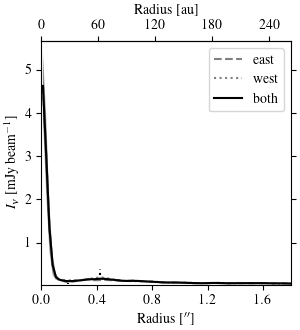

In [9]:
# radial profile of continuum
fig, ax = plt.subplots(figsize=(3, 3.3), constrained_layout=True)
# east
profilename = "./VADP/L1489IRS_SBLB_continuum_robust_1.0.pbcor.tt0_radialProfileWedge45deg_east.txt"
r, I, dI = np.loadtxt(profilename, unpack=True)
I *= 1e3
dI *=1e3
ax.plot(r, I, color="grey", label="east", ls="dashed")
ax.fill_between(r, I-dI, I+dI, alpha=0.2, color="black", edgecolor=None)
# west
profilename = "./VADP/L1489IRS_SBLB_continuum_robust_1.0.pbcor.tt0_radialProfileWedge45deg_west.txt"
r, I, dI = np.loadtxt(profilename, unpack=True)
I *= 1e3
dI *=1e3
ax.plot(r, I, color="grey", label="west", ls="dotted")
ax.fill_between(r, I-dI, I+dI, alpha=0.2, color="black", edgecolor=None)
# full
profilename = "./VADP/L1489IRS_SBLB_continuum_robust_1.0.pbcor.tt0_radialProfileWedge45deg.txt"
r, I, dI = np.loadtxt(profilename, unpack=True)
I *= 1e3
dI *=1e3
ax.plot(r, I, color="black", label="both")
ax.fill_between(r, I-dI, I+dI, alpha=0.2, color="black", edgecolor=None)

topax = ax.secondary_xaxis("top", functions=(arcsec2au, au2arcsec))
topax.xaxis.set_major_locator(ticker.MaxNLocator(5))
ax.xaxis.set_major_locator(ticker.MaxNLocator(5))
ax.tick_params(top=False)
ax.set(yscale="linear", xlim=(0, 1.8), ylim=(2e-2, None), xlabel="Radius [$^{\prime\prime}$]", ylabel="$I_\\nu$ [mJy beam$^{-1}$]")
topax.set(xlabel="Radius [au]")
ax.legend()

ax.vlines(x=0.42, ymin=2.5e-1, ymax=4e-1, color="black", ls="dotted")
ax.vlines(x=0.19, ymin=7e-2, ymax=4e-2, color="black", ls="dotted")

# fig.savefig("./figure/continuum_radial_profile.pdf", bbox_inches="tight", pad_inches=0.01)

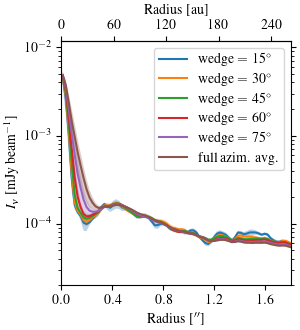

In [3]:
# radial profile of continuum, wedge comparison
fig, ax = plt.subplots(figsize=(3, 3.3), constrained_layout=True)
wedge = [15, 30, 45, 60, 75, 90]

for w in wedge:
    profilename = "./VADP/L1489IRS_SBLB_continuum_robust_1.0.pbcor.tt0_radialProfileWedge{:d}deg.txt".format(w)
    r, I, dI = np.loadtxt(profilename, unpack=True)
    ax.plot(r, I, label="wedge $=$ {}$^\circ$".format(w) if not w == 90 else "full azim. avg.".format(w))
    ax.fill_between(r, I-dI, I+dI, alpha=0.3)


topax = ax.secondary_xaxis("top", functions=(arcsec2au, au2arcsec))
topax.xaxis.set_major_locator(ticker.MaxNLocator(5))
ax.xaxis.set_major_locator(ticker.MaxNLocator(5))
ax.tick_params(top=False)
ax.set(yscale="log", xlim=(0, 1.8), ylim=(2e-5, None), xlabel="Radius [$^{\prime\prime}$]", ylabel="$I_\\nu$ [mJy beam$^{-1}$]")
topax.set(xlabel="Radius [au]")
ax.legend()

# fig.savefig("./figure/comparison_cont_profile_wedge.pdf", bbox_inches="tight", pad_inches=0.01)

Generating threshold mask...
Done.


Text(0.1, 0.9, '(c)')

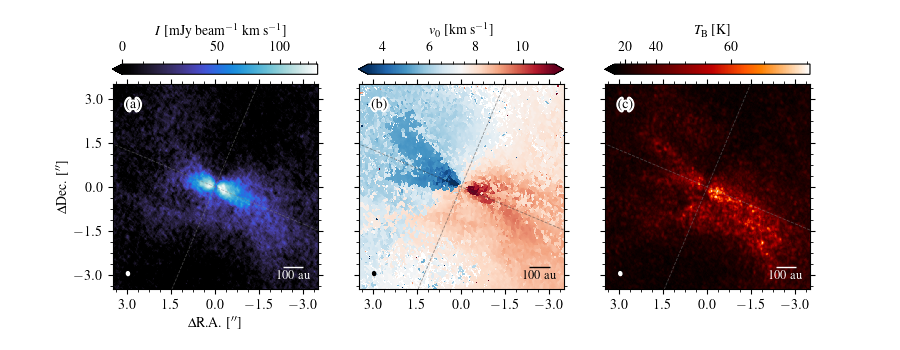

In [15]:
### moment maps of 13CO
line = "13CO"
robust = 1.0
au.VADPpath = "./VADP/"
au.customimagepath = "/works/yamato/eDisk/L1489IRS/custom_images/"
imagename = au.customimagepath + au.get_image_basename(
    source=source, baseline=config, line=line, robust=robust, dv=dv
)
fig, axes = plt.subplots(
    1, 3, figsize=(9, 3.5), sharex=True, sharey=True
)  # , constrained_layout=True)
rmax = 3.5
scale = 100  # in au

# moment0
ax = axes[0]
mom0name = au.VADPpath + au.get_image_basename(
    source=source, baseline=config, line=line, robust=robust, dv=dv
).replace(".fits", "_M0.fits")
mom0map = Map(
    mom0name, ax=ax, center_coord=center_coord, xlim=(-rmax, rmax), ylim=(-rmax, rmax)
)
mom0map.estimate_rms(edgenchan=3)
mom0map.plot_colormap(cmap=eplot.cmap["M0"], vmin=0.0, stretch=AsinhStretch(a=0.4))
# mom0map.overlay_contour(contimagename, levels=np.array([8])*contrms, linewidth=0.6)
mom0map.add_colorbar(
    position="top", label="$I$ [mJy beam$^{-1}$ km s$^{-1}$]", rotation=0, labelpad=5
)
mom0map.add_beam()
mom0map.add_scalebar(scale=scale / distance, text=str(scale) + " au")
mom0map.colorbar.ax.minorticks_on()
mom0map.set_ticker(majornticks=5, minor=True, minornticks=4)
mom0map.set_labels(
    xlabel="$\Delta$R.A. [$^{\prime\prime}$]", ylabel="$\Delta$Dec. [$^{\prime\prime}$]"
)
# mom0map.ax.scatter(0, 0, marker="+", s=50, color="white", linewidth=1)
x, y = mom0map.get_disk_coord(PA=PA, incl=incl, frame="cartesian")
mom0map.overlay_contour(y, x=mom0map.x, y=mom0map.y, levels=[0.0], linewidth=0.6, linestyle="dashed", color="grey", alpha=0.5)
mom0map.overlay_contour(x, x=mom0map.x, y=mom0map.y, levels=[0.0], linewidth=0.6, linestyle="dashed", color="grey", alpha=0.5)
mom0map.ax.annotate(
    text="(a)",
    xy=(0.1, 0.9),
    xycoords="axes fraction",
    color="black",
    ha="center",
    va="center",
    path_effects=[pe.Stroke(linewidth=3, foreground="white"), pe.Normal()],
)

# v0map
ax = axes[1]
vrange = 4
cube = FitsImage(imagename, xlim=(-rmax, rmax), ylim=(-rmax, rmax))
cube.shift_phasecenter_toward(center_coord)
print("Generating threshold mask...")
cube.estimate_rms(edgenchan=3)
cube.get_threshold_mask(threshold=4)
mask = np.sum(cube.threshold_mask, axis=0) > 0
print("Done.")
v0name = au.VADPpath + au.get_image_basename(
    source=source, baseline=config, line=line, robust=robust, dv=dv
).replace(".fits", "_v0.fits")
v0map = Map(
    v0name,
    ax=ax,
    center_coord=center_coord,
    xlim=(-rmax, rmax),
    ylim=(-rmax, rmax),
    data_scaling_factor=1e-3,
    invert_xaxis=False,
)
v0map.mask(vmin=vsys - 2, vmax=vsys + 2, user_mask=mask, combine="or")
v0map.plot_colormap(cmap=eplot.cmap["M1"], vmin=vsys - vrange, vmax=vsys + vrange)
v0map.add_colorbar(position="top", label="$v_0$ [km s$^{-1}$]", rotation=0, labelpad=5)
v0map.add_beam(color="black")
v0map.add_scalebar(scale=scale / distance, text=str(scale) + " au", color="black")
# v0map.ax.scatter(0, 0, marker="+", s=50, color="black", linewidth=0.5)
x, y = v0map.get_disk_coord(PA=PA, incl=incl, frame="cartesian")
v0map.overlay_contour(y, x=mom0map.x, y=mom0map.y, levels=[0.0], linewidth=0.6, linestyle="dashed", color="0.2", alpha=0.5)
v0map.overlay_contour(x, x=mom0map.x, y=mom0map.y, levels=[0.0], linewidth=0.6, linestyle="dashed", color="0.2", alpha=0.5)
v0map.colorbar.ax.minorticks_on()
v0map.ax.annotate(
    text="(b)",
    xy=(0.1, 0.9),
    xycoords="axes fraction",
    color="black",
    ha="center",
    va="center",
    path_effects=[pe.Stroke(linewidth=3, foreground="white"), pe.Normal()],
)

# M8map
ax = axes[2]
mom8name = au.VADPpath + au.get_image_basename(
    source=source, baseline=config, line=line, robust=robust, dv=dv
).replace(".fits", "_Fnu.fits")
peakmap = Map(
    mom8name,
    ax=ax,
    center_coord=center_coord,
    xlim=(-rmax, rmax),
    ylim=(-rmax, rmax),
    invert_xaxis=False,
)
peakmap.convert_unit()
peakmap.plot_colormap(cmap=eplot.cmap["M8"], vmin=10.0, stretch=SinhStretch())
peakmap.add_colorbar(position="top", label="$T_\mathrm{B}$ [K]", rotation=0, labelpad=5)
peakmap.add_beam()
peakmap.add_scalebar(scale=scale / distance, text=str(scale) + " au")
# peakmap.ax.scatter(0, 0, marker="+", s=50, color="white", linewidth=0.5)
x, y = peakmap.get_disk_coord(PA=PA, incl=incl, frame="cartesian")
peakmap.overlay_contour(y, x=mom0map.x, y=mom0map.y, levels=[0.0], linewidth=0.6, linestyle="dashed", color="grey", alpha=0.5)
peakmap.overlay_contour(x, x=mom0map.x, y=mom0map.y, levels=[0.0], linewidth=0.6, linestyle="dashed", color="grey", alpha=0.5)
peakmap.colorbar.ax.minorticks_on()
peakmap.ax.annotate(
    text="(c)",
    xy=(0.1, 0.9),
    xycoords="axes fraction",
    color="black",
    ha="center",
    va="center",
    path_effects=[pe.Stroke(linewidth=3, foreground="white"), pe.Normal()],
)


In [16]:
fig.savefig("./figure/13CO_maps.pdf", bbox_inches="tight", pad_inches=0.01)

/home/yamato/Project/eDisk/firstlook_L1489IRS/.venv/lib/python3.8/site-packages/qdisk/plot.py:219: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  x = self.x


Generating threshold mask...
Done.


Text(0.1, 0.9, '(c)')

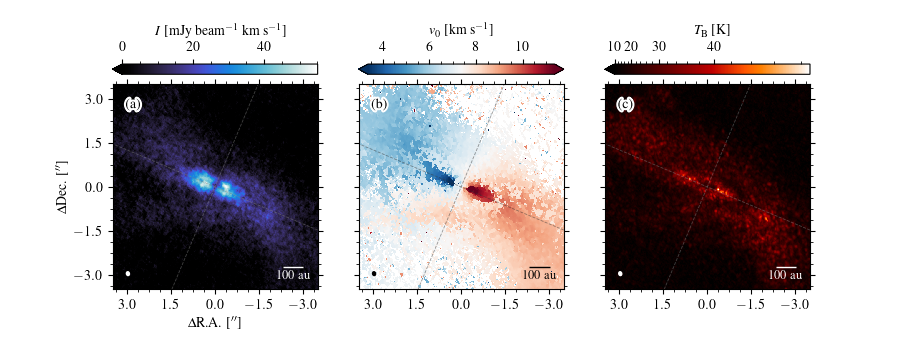

In [17]:
### moment maps of C18O
line = "C18O"
robust = 1.0
imagename = au.customimagepath + au.get_image_basename(
    source=source, baseline=config, line=line, robust=robust, dv=dv
)
fig, axes = plt.subplots(
    1, 3, figsize=(9, 3.5), sharex=True, sharey=True
)  # , constrained_layout=True)
rmax = 3.5
scale = 100  # in au

# moment0
ax = axes[0]
mom0name = au.VADPpath + au.get_image_basename(
    source=source, baseline=config, line=line, robust=robust, dv=dv
).replace(".fits", "_M0.fits")
mom0map = Map(
    mom0name, ax=ax, center_coord=center_coord, xlim=(-rmax, rmax), ylim=(-rmax, rmax)
)
mom0map.plot_colormap(cmap=eplot.cmap["M0"], vmin=0.0)
mom0map.add_colorbar(
    position="top", label="$I$ [mJy beam$^{-1}$ km s$^{-1}$]", rotation=0, labelpad=5
)
mom0map.add_beam()
mom0map.add_scalebar(scale=scale / distance, text=str(scale) + " au")
mom0map.colorbar.ax.minorticks_on()
mom0map.set_ticker(majornticks=5, minor=True, minornticks=4)
mom0map.set_labels(
    xlabel="$\Delta$R.A. [$^{\prime\prime}$]", ylabel="$\Delta$Dec. [$^{\prime\prime}$]"
)
x, y = mom0map.get_disk_coord(PA=PA, incl=incl, frame="cartesian")
mom0map.overlay_contour(y, x=mom0map.x, y=mom0map.y, levels=[0.0], linewidth=0.6, linestyle="dashed", color="grey", alpha=0.5)
mom0map.overlay_contour(x, x=mom0map.x, y=mom0map.y, levels=[0.0], linewidth=0.6, linestyle="dashed", color="grey", alpha=0.5)
mom0map.ax.annotate(
    text="(a)",
    xy=(0.1, 0.9),
    xycoords="axes fraction",
    color="black",
    ha="center",
    va="center",
    path_effects=[pe.Stroke(linewidth=3, foreground="white"), pe.Normal()],
)

# v0map
ax = axes[1]
vrange = 4
cube = FitsImage(imagename, xlim=(-rmax, rmax), ylim=(-rmax, rmax))
cube.shift_phasecenter_toward(center_coord)
print("Generating threshold mask...")
cube.estimate_rms(edgenchan=3)
cube.get_threshold_mask(threshold=4)
mask = np.sum(cube.threshold_mask, axis=0) > 0
print("Done.")
v0name = au.VADPpath + au.get_image_basename(
    source=source, baseline=config, line=line, robust=robust, dv=dv
).replace(".fits", "_v0.fits")
v0map = Map(
    v0name,
    ax=ax,
    center_coord=center_coord,
    xlim=(-rmax, rmax),
    ylim=(-rmax, rmax),
    data_scaling_factor=1e-3,
    invert_xaxis=False,
)
v0map.mask(vmin=vsys - 2, vmax=vsys + 2, user_mask=mask, combine="or")
v0map.plot_colormap(cmap=eplot.cmap["M1"], vmin=vsys - vrange, vmax=vsys + vrange)
v0map.add_colorbar(position="top", label="$v_0$ [km s$^{-1}$]", rotation=0, labelpad=5)
v0map.add_beam(color="black")
v0map.add_scalebar(scale=scale / distance, text=str(scale) + " au", color="black")
v0map.colorbar.ax.minorticks_on()
x, y = v0map.get_disk_coord(PA=PA, incl=incl, frame="cartesian")
v0map.overlay_contour(y, x=mom0map.x, y=mom0map.y, levels=[0.0], linewidth=0.6, linestyle="dashed", color="0.2", alpha=0.5)
v0map.overlay_contour(x, x=mom0map.x, y=mom0map.y, levels=[0.0], linewidth=0.6, linestyle="dashed", color="0.2", alpha=0.5)
v0map.ax.annotate(
    text="(b)",
    xy=(0.1, 0.9),
    xycoords="axes fraction",
    color="black",
    ha="center",
    va="center",
    path_effects=[pe.Stroke(linewidth=3, foreground="white"), pe.Normal()],
)

# M8map
ax = axes[2]
mom8name = au.VADPpath + au.get_image_basename(
    source=source, baseline=config, line=line, robust=robust, dv=dv
).replace(".fits", "_Fnu.fits")
peakmap = Map(
    mom8name,
    ax=ax,
    center_coord=center_coord,
    xlim=(-rmax, rmax),
    ylim=(-rmax, rmax),
    invert_xaxis=False,
)
peakmap.convert_unit()
peakmap.plot_colormap(cmap=eplot.cmap["M8"], vmin=10.0, stretch=SinhStretch())
peakmap.add_colorbar(position="top", label="$T_\mathrm{B}$ [K]", rotation=0, labelpad=5)
peakmap.add_beam()
peakmap.add_scalebar(scale=scale / distance, text=str(scale) + " au")
peakmap.colorbar.ax.minorticks_on()
x, y = peakmap.get_disk_coord(PA=PA, incl=incl, frame="cartesian")
peakmap.overlay_contour(y, x=mom0map.x, y=mom0map.y, levels=[0.0], linewidth=0.6, linestyle="dashed", color="grey", alpha=0.5)
peakmap.overlay_contour(x, x=mom0map.x, y=mom0map.y, levels=[0.0], linewidth=0.6, linestyle="dashed", color="grey", alpha=0.5)
peakmap.ax.annotate(
    text="(c)",
    xy=(0.1, 0.9),
    xycoords="axes fraction",
    color="black",
    ha="center",
    va="center",
    path_effects=[pe.Stroke(linewidth=3, foreground="white"), pe.Normal()],
)


In [18]:
fig.savefig("./figure/C18O_maps.pdf", bbox_inches="tight", pad_inches=0.01)

Generating threshold mask...
Done.


Text(0.1, 0.9, '(c)')

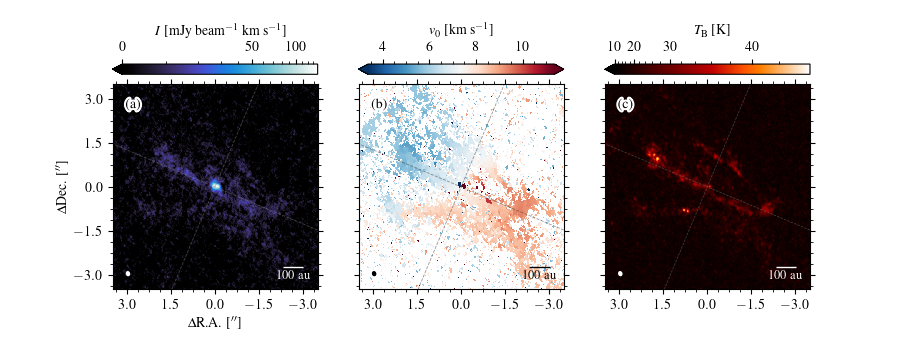

In [21]:
### moment maps of SO
line = "SO"
robust = 1.0
imagename = au.customimagepath + au.get_image_basename(source=source, baseline=config, line=line, robust=robust, dv=dv)
fig, axes = plt.subplots(1, 3, figsize=(9,3.5), sharex=True, sharey=True)#, constrained_layout=True)
rmax = 3.5
scale = 100 # in au

# moment0
ax = axes[0]
mom0name = au.VADPpath + au.get_image_basename(source=source, baseline=config, line=line, robust=robust, dv=dv).replace(".fits", "_M0.fits")
mom0map = Map(mom0name, ax=ax, center_coord=center_coord, xlim=(-rmax, rmax), ylim=(-rmax, rmax))
mom0map.plot_colormap(cmap=eplot.cmap["M0"], vmin=0.0, stretch=AsinhStretch())
mom0map.add_colorbar(position="top", label="$I$ [mJy beam$^{-1}$ km s$^{-1}$]", rotation=0, labelpad=5)
mom0map.add_beam()
mom0map.add_scalebar(scale=scale/distance, text=str(scale)+" au")
mom0map.colorbar.ax.minorticks_on()
mom0map.set_ticker(majornticks=5, minor=True, minornticks=4)
mom0map.set_labels(xlabel="$\Delta$R.A. [$^{\prime\prime}$]", ylabel="$\Delta$Dec. [$^{\prime\prime}$]")
x, y = mom0map.get_disk_coord(PA=PA, incl=incl, frame="cartesian")
mom0map.overlay_contour(y, x=mom0map.x, y=mom0map.y, levels=[0.0], linewidth=0.6, linestyle="dashed", color="grey", alpha=0.5)
mom0map.overlay_contour(x, x=mom0map.x, y=mom0map.y, levels=[0.0], linewidth=0.6, linestyle="dashed", color="grey", alpha=0.5)
mom0map.ax.annotate(
    text="(a)",
    xy=(0.1, 0.9),
    xycoords="axes fraction",
    color="black",
    ha="center",
    va="center",
    path_effects=[pe.Stroke(linewidth=3, foreground="white"), pe.Normal()],
)

# v0map
ax = axes[1]
vrange = 4
cube = FitsImage(imagename, xlim=(-rmax, rmax), ylim=(-rmax, rmax))
cube.shift_phasecenter_toward(center_coord)
print("Generating threshold mask...")
cube.estimate_rms(edgenchan=3)
cube.get_threshold_mask(threshold=4)
mask = np.sum(cube.threshold_mask, axis=0) > 0
print("Done.")
v0name = au.VADPpath + au.get_image_basename(source=source, baseline=config, line=line, robust=robust, dv=dv).replace(".fits", "_v0.fits")
v0map = Map(v0name, ax=ax, center_coord=center_coord, xlim=(-rmax, rmax), ylim=(-rmax, rmax), data_scaling_factor=1e-3, invert_xaxis=False)
v0map.mask(vmin=vsys-2, vmax=vsys+2, user_mask=mask, combine="or")
v0map.plot_colormap(cmap=eplot.cmap["M1"], vmin=vsys-vrange, vmax=vsys+vrange)
v0map.add_colorbar(position="top", label="$v_0$ [km s$^{-1}$]", rotation=0, labelpad=5)
v0map.add_beam(color="black")
v0map.add_scalebar(scale=scale/distance, text=str(scale)+" au", color="black")
v0map.colorbar.ax.minorticks_on()
x, y = v0map.get_disk_coord(PA=PA, incl=incl, frame="cartesian")
v0map.overlay_contour(y, x=mom0map.x, y=mom0map.y, levels=[0.0], linewidth=0.6, linestyle="dashed", color="0.2", alpha=0.5)
v0map.overlay_contour(x, x=mom0map.x, y=mom0map.y, levels=[0.0], linewidth=0.6, linestyle="dashed", color="0.2", alpha=0.5)
v0map.ax.annotate(
    text="(b)",
    xy=(0.1, 0.9),
    xycoords="axes fraction",
    color="black",
    ha="center",
    va="center",
    path_effects=[pe.Stroke(linewidth=3, foreground="white"), pe.Normal()],
)

# M8map
ax = axes[2]
mom8name = au.VADPpath + au.get_image_basename(source=source, baseline=config, line=line, robust=robust, dv=dv).replace(".fits", "_Fnu.fits")
peakmap = Map(mom8name, ax=ax, center_coord=center_coord, xlim=(-rmax, rmax), ylim=(-rmax, rmax), invert_xaxis=False)
peakmap.convert_unit()
peakmap.plot_colormap(cmap=eplot.cmap["M8"], vmin=10.0, stretch=SinhStretch())
peakmap.add_colorbar(position="top", label="$T_\mathrm{B}$ [K]", rotation=0, labelpad=5)
peakmap.add_beam()
peakmap.add_scalebar(scale=scale/distance, text=str(scale)+" au")
peakmap.colorbar.ax.minorticks_on()
x, y = mom0map.get_disk_coord(PA=PA, incl=incl, frame="cartesian")
peakmap.overlay_contour(y, x=mom0map.x, y=mom0map.y, levels=[0.0], linewidth=0.5, linestyle="dashed", color="grey", alpha=0.5)
peakmap.overlay_contour(x, x=mom0map.x, y=mom0map.y, levels=[0.0], linewidth=0.5, linestyle="dashed", color="grey", alpha=0.5)
peakmap.ax.annotate(
    text="(c)",
    xy=(0.1, 0.9),
    xycoords="axes fraction",
    color="black",
    ha="center",
    va="center",
    path_effects=[pe.Stroke(linewidth=3, foreground="white"), pe.Normal()],
)

In [22]:
fig.savefig(au.figurepath + "SO_maps.pdf", bbox_inches="tight", pad_inches=0.01)

/home/yamato/Project/eDisk/firstlook_L1489IRS/analysis_utils.py:278: RuntimeWarning: divide by zero encountered in divide
  I = 2 * h * nu**3 / c**2 / (np.exp(h * nu / (k_B * np.abs(T))) - 1)


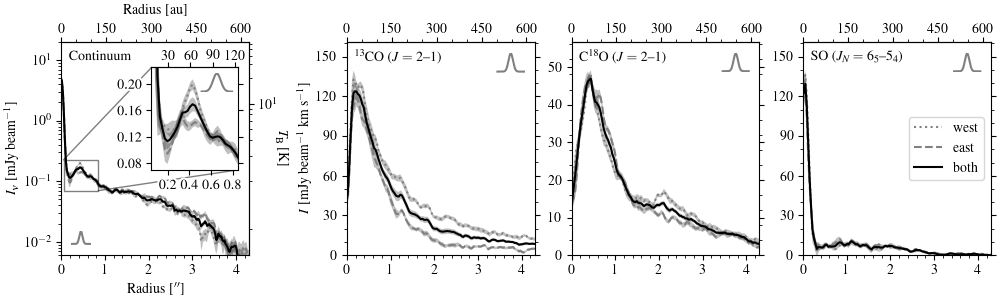

In [21]:
### radial profiles

au.VADPpath = "./VADP/"
    


fig, axes = plt.subplots(1, 4, figsize=(10, 3), sharex=True, constrained_layout=True)
lines = ["continuum", "13CO", "C18O", "SO"]
robust = 1.0
dv = 0.2

# ax_list = []

for i, line in enumerate(lines):
    for side in ["West", "East", ""]:
        if line == "continuum":
            profilename = au.VADPpath + au.get_image_basename(
                source=source, line=line, baseline=config, robust=robust, type="pbcor"
            ).replace(".fits", f"_radialProfileWedge45deg{side}.txt")
        else:
            profilename = au.VADPpath + au.get_image_basename(
                source=source, line=line, baseline=config, robust=robust, dv=dv
            ).replace(".fits", f"_radialProfileWedge45deg{side}.txt")

        r, I, dI = np.loadtxt(profilename, unpack=True)
        if line == "continuum":
            I *= 1e3
            dI *= 1e3

        ax = axes[i]
        color = "black" if side == "" else "grey"
        ls = "solid" if side == "" else "dotted" if side == "West" else "dashed"
        ax.plot(r, I, color=color, ls=ls, label=side.lower() if side != "" else "both")
        ax.fill_between(r, I-dI, I+dI, alpha=0.25, facecolor="black", edgecolor=None)
        ax.set(xlim=(0, 4.3))

    topax = ax.secondary_xaxis("top", functions=(arcsec2au, au2arcsec))
    topax.tick_params(axis='x', which='major', pad=1)
    topax.xaxis.set_major_locator(ticker.MultipleLocator(150))
    topax.xaxis.set_minor_locator(ticker.MultipleLocator(50))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.2))
    # ax.minorticks_on()
    ax.tick_params(top=False, which="both")
    

    if line == "continuum":
        ax.set(yscale="log", ylim=(2e-2, 2e1), ylabel="$I_\\nu$ [mJy beam$^{-1}$]", xlabel="Radius [$^{\prime\prime}$]")
        topax.set_xlabel("Radius [au]", labelpad=7)
        # topax.set
        # topax.minorticks_on()
        ax.annotate(
            text="Continuum",
            xy=(0.04, 0.93),
            xycoords="axes fraction",
            color="black",
            ha="left",
            va="center",
            path_effects=[pe.Stroke(linewidth=3, foreground="white"), pe.Normal()],
        )
        add_beam_profile(ax, beam=4*np.diff(r).mean(), loc="lower left")

        # inset axis for zoom
        insax = ax.inset_axes([0.48, 0.4, 0.46, 0.48])
        xmin, xmax, ymin, ymax = 0.05, 0.85, 0.07, 0.225
        insax.set(xlim=(xmin, xmax), ylim=(ymin, ymax))
        topinsax = insax.secondary_xaxis("top", functions=(arcsec2au, au2arcsec))
        insax.tick_params(top=False)
        topinsax.xaxis.set_major_locator(ticker.MultipleLocator(30))
        topinsax.tick_params(axis='x', which='major', pad=0.1)
        insax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
        insax.yaxis.set_major_locator(ticker.MultipleLocator(0.04))

        # set patheffect
        for ticks in insax.get_xticklabels():
            ticks.set_path_effects([pe.Stroke(linewidth=3, foreground="white"), pe.Normal()])
        for ticks in insax.get_yticklabels():
            ticks.set_path_effects([pe.Stroke(linewidth=3, foreground="white"), pe.Normal()])
        for side in ["West", "East", ""]:
            profilename = au.VADPpath + au.get_image_basename(
                    source=source, line=line, baseline=config, robust=robust, type="pbcor"
                ).replace(".fits", f"_radialProfileWedge45deg{side}.txt")

            r, I, dI = np.loadtxt(profilename, unpack=True)
            I *= 1e3
            dI *= 1e3

            color = "black" if side == "" else "grey"
            ls = "solid" if side == "" else "dotted" if side == "West" else "dashed"
            insax.plot(r, I, color=color, ls=ls)
            insax.fill_between(r, I-dI, I+dI, alpha=0.25, facecolor="black", edgecolor=None)
        ax.indicate_inset_zoom(insax, edgecolor="black")
        ax.set(ylim=(6e-3, 2e1))
        add_beam_profile(insax, beam=4*np.diff(r).mean(), aspect=0.5, width_aspect=0.3)

        def jypb2K(I):
            return au.jypb_to_K(I*1e-3, nu0, contimage.beam[:2])

        def K2jypb(I):
            return au.K_to_jypb(I, nu0, contimage.beam[:2])

        rightax = ax.secondary_yaxis("right", functions=(jypb2K, K2jypb))
        ax.tick_params(which="both", right=False)
        rightax.set_ylabel("$T_\mathrm{B}$ [K]", labelpad=7, rotation=270)

        
        # l, b, w, h = ax.get_position().bounds
        # ax.set_position([l - 0.1*w, b, w, h])
    else:
        ax.set(ylim=(0.0, ax.get_ylim()[1]*1.1), yscale="linear")
        ax.annotate(
            text=eplot.linelabel[line],
            xy=(0.04, 0.93),
            xycoords="axes fraction",
            color="black",
            ha="left",
            va="center",
            path_effects=[pe.Stroke(linewidth=3, foreground="white"), pe.Normal()],
        )
        add_beam_profile(ax, beam=4*np.diff(r).mean(), loc="upper right")
        ax.yaxis.set_major_locator(ticker.MaxNLocator(6))
        ax.yaxis.set_minor_locator(ticker.MaxNLocator(18))
        # ax.minorticks_on()

    # ax_list.append(ax)

# axes[0].get_shared_y_axes().join(axes[0], *axes)
# axes[2].sharey(axes[1])
# axes[3].sharey(axes[1])
axes[1].set(ylabel="$I$ [mJy beam$^{-1}$ km s$^{-1}$]")#, xlabel="Radius [$^{\prime\prime}$]")
axes[3].legend(loc="center right")


# ax = axes[3]
# beam = 4*np.diff(r).mean()
# xmin, xmax = ax.get_xlim()
# width = 5*beam / (xmax - xmin)
# height = width * 0.6
# insax = ax.inset_axes([0.95-width, 0.95-height, width, height])
# x = np.arange(-0.5, 0.5, 0.001)
# from analysis_utils import FWHM_to_sigma
# beam_sigma = FWHM_to_sigma(0.2)
# y = np.exp(- x**2/(2*beam_sigma**2))
# insax.plot(x, y, color="grey")
# insax.axis("off")

        
# 

In [ ]:
fig.savefig("./figure/radial_emission_profile.pdf", bbox_inches="tight", pad_inches=0.01)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


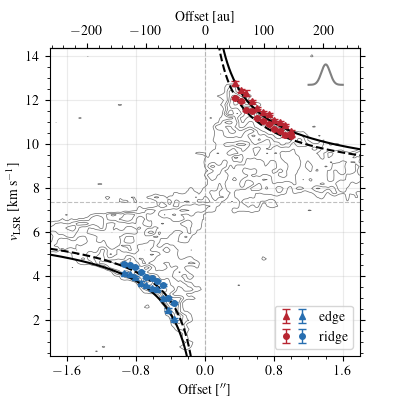

In [2]:
from mcmc_tools import EmceeHammer
from qdisk.plot import PVDiagram
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np
from matplotlib.legend_handler import HandlerTuple
from eDisk_source_dict import source_dict
import eDiskplot
import analysis_utils as au

%matplotlib widget
%load_ext autoreload
%autoreload 2

source = "L1489IRS"
distance = source_dict[source]["distance"]
vsys = source_dict[source]["vsys"]
incl = source_dict[source]["incl"]

def arcsec2au(r):
    return r * distance

def au2arcsec(r):
    return r / distance

### add beam prfoiel
def add_beam_profile(ax, beam, width_aspect=0.2, loc="upper right", aspect=0.6):
    xmin, xmax = ax.get_xlim()
    width = beam / (xmax - xmin) / width_aspect
    height = width * aspect
    if loc == "upper right":
        loc = [0.95-width, 0.95-height, width, height]
    elif loc == "lower left":
        loc = [0.05, 0.05, width, height]
    insax = ax.inset_axes(loc)
    x = np.arange(-0.5, 0.5, 0.001)
    beam_sigma = au.FWHM_to_sigma(width_aspect)
    y = np.exp(- x**2/(2*beam_sigma**2))
    insax.plot(x, y, color="grey")
    insax.axis("off")

cmap = matplotlib.cm.get_cmap("RdBu")
red = cmap(0.12)
blue = cmap(0.88)

param_name = ["Mstar", "vsys"]
fitmode = ["edge", "ridge"]

### plot C18O PV diagram
imagename = "./VADP/L1489IRS_SBLB_C18O_robust_1.0_dv0.2.pbcor.PV_PA67.2deg.fits"
rms = 1.6  # in mJy/beam
rmax = 1.8
vrange = 7
fig, ax = plt.subplots(figsize=(4, 4))
pvmap = PVDiagram(imagename, data_scaling_factor=1e3, ax=ax)
# pvmap.plot_colormap(cmap=eplot.cmap["M0"], vmin=0.0)
pvmap.overlay_contour(
    levels=np.array([3, 5, 7, 9, 11, 13, 15]) * rms, color="dimgray", linewidth=0.5
)

### extrcated data points by SLAM
nom_vsys = []
handles = []
for mode in fitmode:
    datafilename = f"./SLAM/results/L1489IRS_SBLB_C18O_robust_1.0_dv0.2.image_pvDiagram_PA67.2.{mode}.dat"
    x, _, v, dv = np.loadtxt(datafilename, unpack=True)
    lr = pvmap.ax.errorbar(
        x[x > 0] / distance,
        v[x > 0] + vsys,
        yerr=dv[x > 0],
        fmt="^" if mode == "edge" else "o",
        markersize=4,
        color=red,
        capsize=3,
        lw=1
    )
    lb = pvmap.ax.errorbar(
        x[x < 0] / distance,
        v[x < 0] + vsys,
        yerr=dv[x < 0],
        fmt="^" if mode == "edge" else "o",
        markersize=4,
        color=blue,
        capsize=3,
        lw=1
    )
    handles.append((lr, lb))

    ### overplot Keplerian model
    ham = EmceeHammer()
    ham.load_backend(f"./fit/L1489IRS_C18O_Keplerian_fit_{mode}.h5")
    best_params = {pname: pval for pname, pval in zip(param_name, ham.get_MAP_params())}
    pvmap.add_Keplerian_curve(
        Mstar=best_params["Mstar"],
        distance=distance,
        incl=incl,
        vsys=best_params["vsys"],
        rotation_sense=-1,
        color="black",
        ls="solid" if mode == "edge" else "dashed",
    )
    nom_vsys.append(best_params["vsys"])

nom_vsys = np.mean(nom_vsys)
### appearance
pvmap.ax.set(
    xlim=(-rmax, rmax),
    ylim=(nom_vsys - vrange, nom_vsys + vrange), xlabel="Offset [$^{\prime\prime}$]", ylabel="$v_\mathrm{LSR}$ [km s$^{-1}$]"
)
pvmap.ax.tick_params(top=False, which="both")
pvmap.set_xaxis_ticker(minor=True, majornticks=5, minornticks=5)
pvmap.ax.minorticks_on()

### topax
topax = pvmap.ax.secondary_xaxis("top", functions=(arcsec2au, au2arcsec))
topax.xaxis.set_major_locator(ticker.MultipleLocator(100))
topax.xaxis.set_minor_locator(ticker.MultipleLocator(20))
topax.set_xlabel("Offset [au]")

pvmap.ax.grid(alpha=0.25)
pvmap.ax.axhline(y=nom_vsys, color="grey", lw=0.8, alpha=0.5, ls="dashed")
pvmap.ax.axvline(x=0.0, color="grey", lw=0.8, alpha=0.5, ls="dashed")
pvmap.ax.legend(handles, fitmode, numpoints=1, handler_map={tuple: HandlerTuple(ndivide=None)}, loc="lower right")


add_beam_profile(ax=pvmap.ax, beam=pvmap.bmaj, width_aspect=0.3)

fig.savefig("./figure/C18O_PV_diagram_datapoints_curve.pdf", bbox_inches="tight", pad_inches=0.01)


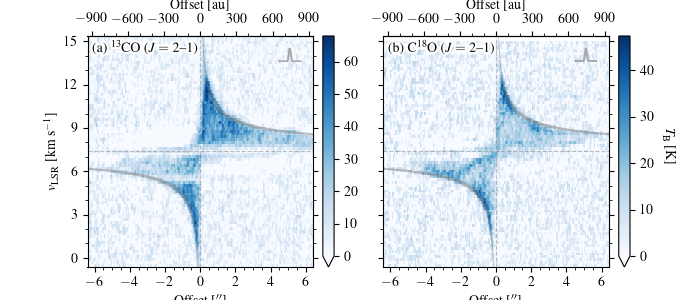

In [126]:
import eDiskplot as eplot
from eDisk_source_dict import source_dict
import matplotlib.patheffects as pe

source = "L1489IRS"
vsys = source_dict[source]["vsys"]
# Mstar = source_dict[source]["Mstar"]
Mstar = (1.498, 1.911)
distance = source_dict[source]["distance"]
incl = source_dict[source]["incl"]

def arcsec2au(r):
    return r * distance

def au2arcsec(r):
    return r / distance

### add beam prfoiel
def add_beam_profile(ax, beam, width_aspect=0.2, loc="upper right", aspect=0.6, **kwargs):
    xmin, xmax = ax.get_xlim()
    width = beam / (xmax - xmin) / width_aspect
    height = width * aspect
    if loc == "upper right":
        loc = [0.95-width, 0.95-height, width, height]
    elif loc == "lower left":
        loc = [0.05, 0.05, width, height]
    insax = ax.inset_axes(loc)
    x = np.arange(-0.5, 0.5, 0.001)
    beam_sigma = au.FWHM_to_sigma(width_aspect)
    y = np.exp(- x**2/(2*beam_sigma**2))
    color = kwargs.pop("color", "grey")
    insax.plot(x, y, color=color, **kwargs)
    insax.axis("off")

### PV diagrams of C18O and 13CO
imagename = {"13CO": "./VADP/L1489IRS_SBLB_13CO_robust_1.0_dv0.2.pbcor.PV_PA67.2deg.fits", "C18O": "./VADP/L1489IRS_SBLB_C18O_robust_1.0_dv0.2.pbcor.PV_PA67.2deg.fits"}
rmax = 6.4
label = ["(a)", "(b)"]

fig, axes = plt.subplots(1,2, figsize=(7,3), sharex=True, sharey=True)#, constrained_layout=True)

for i, (ax, line) in enumerate(zip(axes, imagename.keys())):
    pvmap = PVDiagram(imagename[line], ax=ax)
    pvmap.convert_unit()
    pvmap.plot_colormap(cmap="Blues", vmin=0.0)
    pvmap.add_Keplerian_curve(Mstar=Mstar, distance=distance, incl=incl, vsys=vsys, rotation_sense=-1, color="gray", alpha=0.5, edgecolor=None)
    pvmap.ax.set(xlim=(-rmax, rmax), ylim=(vsys-8, vsys+8), facecolor="white", xlabel="Offset [$^{\prime\prime}$]", ylabel="$v_\mathrm{LSR}$ [km s$^{-1}$]" if i == 0 else None)
    pvmap.ax.tick_params(top=False, which="both")
    # pvmap.ax.minorticks_on()
    pvmap.set_xaxis_ticker(minor=True, majornticks=7, minornticks=28)
    pvmap.set_yaxis_ticker(minor=True, majornticks=6, minornticks=18)
    
    pvmap.ax.axhline(y=nom_vsys, color="grey", lw=0.8, alpha=0.5, ls="dashed")
    pvmap.ax.axvline(x=0.0, color="grey", lw=0.8, alpha=0.5, ls="dashed")
    pvmap.add_colorbar(label="$T_\mathrm{B}$ [K]" if i == 1 else None, labelpad=15)
    # pvmap.ax.grid(alpha=0.25)
    pvmap.ax.annotate(
            text=label[i] + " " + eplot.linelabel[line],
            xy=(0.02, 0.98),
            xycoords="axes fraction",
            color="black",
            ha="left",
            va="top",
            path_effects=[pe.Stroke(linewidth=3, foreground="white"), pe.Normal()],
        )

    add_beam_profile(ax=pvmap.ax, beam=pvmap.bmaj, width_aspect=0.1, color="darkgrey")

    ### topax
    topax = pvmap.ax.secondary_xaxis("top", functions=(arcsec2au, au2arcsec))
    topax.xaxis.set_major_locator(ticker.MultipleLocator(300))
    topax.xaxis.set_minor_locator(ticker.MultipleLocator(100))
    topax.set_xlabel("Offset [au]")

    fig.savefig("./figure/13CO_C18O_PV_diagram.pdf", bbox_inches="tight", pad_inches=0.01)

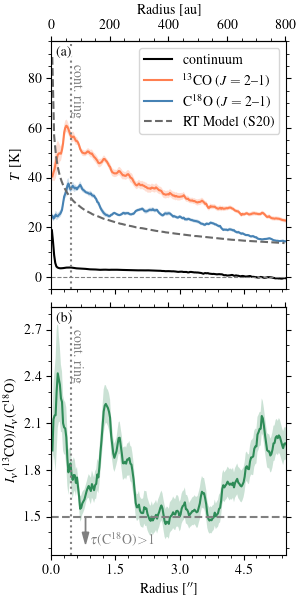

In [246]:
from eDisk_source_dict import source_dict

source = "L1489IRS"
distance = source_dict[source]["distance"]

def add_beam_profile(ax, beam, width_aspect=0.2, loc="upper right", aspect=0.6, **kwargs):
    xmin, xmax = ax.get_xlim()
    width = beam / (xmax - xmin) / width_aspect
    height = width * aspect
    if loc == "upper right":
        loc = [0.95-width, 0.95-height, width, height]
    elif loc == "lower left":
        loc = [0.05, 0.05, width, height]
    else:
        loc = [*loc, width, height]
    insax = ax.inset_axes(loc)
    x = np.arange(-0.5, 0.5, 0.001)
    beam_sigma = au.FWHM_to_sigma(width_aspect)
    y = np.exp(- x**2/(2*beam_sigma**2))
    color = kwargs.pop("color", "grey")
    insax.plot(x, y, color=color, **kwargs)
    insax.axis("off")

### radial profiles of temperature and line ratio
profiledict = {
    "continuum": "./data/continuum_robust1.0_radial_profile_Tb.npz",
    "13CO": "./data/13CO_peak_radial_profile_Tb.npz",
    "C18O": "./data/C18O_peak_radial_profile_Tb.npz",
}

color = {"continuum": "black", "13CO": "coral", "C18O": "steelblue"}

fig, axes = plt.subplots(2,1, figsize=(3,6), sharex=True, constrained_layout=True)

ax = axes[0]
for line in profiledict.keys():
    # load the data
    data = np.load(profiledict[line])
    r = data["r"]
    Tb = data["Tb"]
    dTb = data["dTb"]
    
    # plot
    ax.plot(r, Tb, color=color[line], label=eplot.linelabel[line] if line != "continuum" else line)
    ax.fill_between(r, Tb-dTb, Tb+dTb, alpha=0.25, color=color[line], edgecolor=None)

modelprofilename = "./data/Sai20_model_Tdust_profile.npz"
data = np.load(modelprofilename)
ax.plot(data["r"]/distance, data["T"], color="dimgrey", ls="dashed", label="RT Model (S20)")

ax.set(yscale="linear", xlim=(0, 5.5), ylim=(-5, 95), ylabel="$T$ [K]")
ax.axhline(y=0.0, color="grey", ls="dashed", lw=0.8)
ax.axvline(x=0.45, color="grey", ls="dotted")
ax.annotate(
            text="(a)",
            xy=(0.02, 0.98),
            xycoords="axes fraction",
            color="black",
            ha="left",
            va="top",
            path_effects=[pe.Stroke(linewidth=3, foreground="white"), pe.Normal()],
        )
_, ymax = ax.get_ylim()
ax.annotate(text="cont. ring",
            xy=(0.45, ymax*0.9),
            xycoords="data",
            color="grey",
            ha="left",
            va="top",
            rotation=270,)
            # path_effects=[pe.Stroke(linewidth=3, foreground="white"), pe.Normal()],)
ax.legend()
ax.yaxis.set_major_locator(ticker.MaxNLocator(5))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.tick_params(which="both", top=False)
topax = ax.secondary_xaxis("top", functions=(arcsec2au, au2arcsec))
topax.xaxis.set_major_locator(ticker.MaxNLocator(5))
topax.xaxis.set_minor_locator(ticker.MultipleLocator(50))
topax.set_xlabel("Radius [au]")


### ratio
ax = axes[1]
ratioprofilename = "./data/13CO_C18O_peak_ratio_radial_profile.npz"
data = np.load(ratioprofilename)
ax.plot(data["r"], data["ratio"], color="seagreen")
ax.fill_between(data["r"], data["ratio"]-data["dratio"], data["ratio"]+data["dratio"], alpha=0.25, color="seagreen", edgecolor=None)
ax.axvline(x=0.45, color="grey", ls="dotted")
ax.axhline(y=1.5, color="grey", ls="dashed")
ax.annotate(
            text="(b)",
            xy=(0.02, 0.98),
            xycoords="axes fraction",
            color="black",
            ha="left",
            va="top",
            path_effects=[pe.Stroke(linewidth=3, foreground="white"), pe.Normal()],
        )
_, ymax = ax.get_ylim()
ax.annotate(text="cont. ring",
            xy=(0.45, ymax*0.95),
            xycoords="data",
            color="grey",
            ha="left",
            va="top",
            rotation=270,)
ax.annotate(r"$\tau$(C$^{18}$O)$>$1", xy=(0.9, 1.35), xycoords="data", color="grey", ha="left", va="center")
ax.arrow(x=0.8, y=1.5, dx=0.0, dy=-0.1, head_width=0.15, head_length=0.075, color="grey")
ax.set(ylabel="$I_\\nu$($^{13}$CO)/$I_\\nu$(C$^{18}$O)", xlabel="Radius [$^{\prime\prime}$]")
ax.xaxis.set_major_locator(ticker.MaxNLocator(5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.3))
ax.yaxis.set_major_locator(ticker.MaxNLocator(6))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
ax.tick_params(which="both", top=False)
topax = ax.secondary_xaxis("top", functions=(arcsec2au, au2arcsec))
topax.xaxis.set_major_locator(ticker.MaxNLocator(5))
topax.xaxis.set_minor_locator(ticker.MultipleLocator(50))
topax.tick_params(labeltop=False)

fig.savefig("./figure/temperature_profiles.pdf", bbox_inches="tight", pad_inches=0.01)


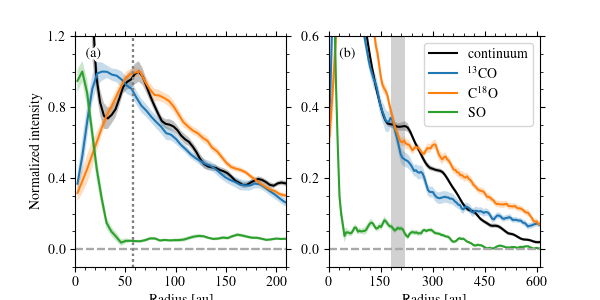

In [34]:
### comparison of radial profiles
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np
from eDisk_source_dict import source_dict
import eDiskplot as eplot
import matplotlib.patheffects as pe
%matplotlib widget

source = "L1489IRS"
distance = source_dict[source]["distance"]

lines = ["continuum", "13CO", "C18O", "SO"]
colors = {"13CO": "tab:blue", "C18O": "tab:orange", "SO": "tab:green"}

fig, axes = plt.subplots(1, 2, figsize=(6, 3))

ax = axes[0]
for line in lines:
    if line == "continuum":
        profilename = "./VADP_newDDT/L1489IRS_SBLB_continuum_robust_1.0.image.tt0_radialProfileWedge45deg.txt"
    else:
        profilename = f"./VADP/L1489IRS_SBLB_{line}_robust_1.0_dv0.2.image_radialProfileWedge45deg.txt"
    
    r, I, dI = np.loadtxt(profilename, unpack=True)
    r *= distance
    # normalize
    if line == "continuum":
        dI /= np.nanmax(I[r > 40])
        I /= np.nanmax(I[r > 40])
        color = "black"
    else:
        dI /= np.nanmax(I)
        I /= np.nanmax(I)
        color = colors[line]

    ax.plot(r, I, color=color, label=line if line == "continuum" else eplot.linelabel_noqn[line])
    ax.fill_between(r, I-dI, I+dI, alpha=0.25, color=color, edgecolor=None)
    ax.axhline(y=0.0, color="darkgrey", ls="dashed")
    ax.axvline(x=58, color="grey", ls="dotted")
    ax.set(ylim=(-0.1, 1.2), xlim=(0, 210), xlabel="Radius [au]", ylabel="Normalized intensity")
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.4))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(10))

    ax.annotate(
            text="(a)",
            xy=(0.05, 0.95),
            xycoords="axes fraction",
            color="black",
            ha="left",
            va="top",
            path_effects=[pe.Stroke(linewidth=3, foreground="white"), pe.Normal()],
        )

# ax.legend()
# ax.grid(alpha=0.25)

ax = axes[1]
for line in lines:
    if line == "continuum":
        profilename = "./VADP_newDDT/L1489IRS_SBLB_continuum_robust_1.0_taper_1000klambda.image.tt0_radialProfileWedge45deg.txt"
    else:
        profilename = f"./VADP/L1489IRS_SBLB_{line}_robust_1.0_dv0.2.image_radialProfileWedge45deg.txt"
    
    r, I, dI = np.loadtxt(profilename, unpack=True)
    r *= distance
    # normalize
    if line == "continuum":
        dI /= np.nanmax(I[r > 40])
        I /= np.nanmax(I[r > 40])
        color = "black"
    else:
        dI /= np.nanmax(I)
        I /= np.nanmax(I)
        color = colors[line]

    ax.plot(r, I, color=color, label=line if line == "continuum" else eplot.linelabel_noqn[line])
    ax.fill_between(r, I-dI, I+dI, alpha=0.25, color=color, edgecolor=None)
    ax.axhline(y=0.0, color="darkgrey", ls="dashed")
    # ax.axvline(x=58, color="grey", ls="dotted")
    ax.axvspan(180, 220, facecolor="grey", alpha=0.1, edgecolor=None)
    ax.set(ylim=(-0.05, 0.6), xlim=(0, 610), xlabel="Radius [au]")
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(150))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(30))

    ax.annotate(
            text="(b)",
            xy=(0.05, 0.95),
            xycoords="axes fraction",
            color="black",
            ha="left",
            va="top",
            path_effects=[pe.Stroke(linewidth=3, foreground="white"), pe.Normal()],
        )

ax.legend()




In [ ]:
fig.savefig("./figure/radial_profile_comparison_inner_outer.pdf", bbox_inches="tight", pad_inches=0.01)

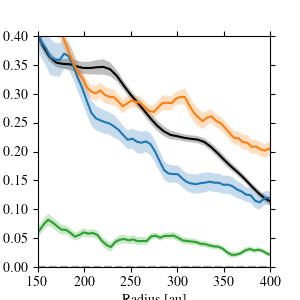

In [4]:
### comparison of radial profiles
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np
from eDisk_source_dict import source_dict
import eDiskplot as eplot
%matplotlib widget

source = "L1489IRS"
distance = source_dict[source]["distance"]

lines = ["continuum", "13CO", "C18O", "SO"]
# lines = ["C18O"]
colors = {"13CO": "tab:blue", "C18O": "tab:orange", "SO": "tab:green"}

fig, ax = plt.subplots(figsize=(3, 3))

for line in lines:
    if line == "continuum":
        profilename = "./VADP_newDDT/L1489IRS_SBLB_continuum_robust_1.0_taper_1000klambda.image.tt0_radialProfileWedge45deg.txt"
    else:
        profilename = f"./VADP/L1489IRS_SBLB_{line}_robust_1.0_dv0.2.image_radialProfileWedge45deg.txt"
    
    r, I, dI = np.loadtxt(profilename, unpack=True)
    r *= distance
    # normalize
    if line == "continuum":
        dI /= np.nanmax(I[r > 40])
        I /= np.nanmax(I[r > 40])
        color = "black"
    else:
        dI /= np.nanmax(I)
        I /= np.nanmax(I)
        color = colors[line]

    ax.plot(r, I, color=color, label=line if line == "continuum" else eplot.linelabel_noqn[line])
    ax.fill_between(r, I-dI, I+dI, alpha=0.25, color=color, edgecolor=None)
    ax.axhline(y=0.0, color="darkgrey", ls="dashed")
    ax.axvline(x=1.1)
    ax.axvline(x=58, color="grey", ls="dotted")
    ax.set(xlabel="Radius [au]", ylabel="Normalized intensity", xlim=(150, 400), ylim=(0.0, 0.4))
    # ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
    # ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
    # ax.xaxis.set_major_locator(ticker.MultipleLocator(150))
    # ax.xaxis.set_minor_locator(ticker.MultipleLocator(30))

# ax.legend()
# ax.grid(alpha=0.25)

